In [108]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import src.kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# #
#from torch_geometric.utils import to_networkx
# import networkx as nx

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
from rgcn_model import RGCN

import stat
import numpy as np
from scipy.stats import chi2_contingency

In [8]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [90]:
from src.rgcn_explainer_utils import *
name = 'aifb'
if name in ['aifb', 'mutag', 'bgs', 'am', 'mdgenre']:
    data = kg.load(name, torch=True, final=False)
if 'IMDb' in name:    
    data = torch.load(f'data/IMDB/finals/{name}.pt')
if 'dbo' in name:
    data = torch.load(f'data/DBO/finals/{name}.pt')
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)
print('rel:', data.num_relations, 'ent:', data.num_entities, 'triples:', data.triples.shape)
print('training', data.training.shape, 'withheld', data.withheld.shape)

loaded data aifb (0.5607s).
rel: 45 ent: 8285 triples: torch.Size([29043, 3])
training torch.Size([103, 2]) withheld torch.Size([35, 2])


RELATION DISTRIBUTION

In [122]:
def bar_plot_relations(full_graph_relations, explanation_subgraph_relations,label_class=None):
    
    # Convert dictionaries to pandas DataFrame
    full_graph_df = pd.DataFrame(list(full_graph_relations.items()), columns=['Relation Name', 'Count'])
    explanation_df = pd.DataFrame(list(explanation_subgraph_relations.items()), columns=['Relation Name', 'Count'])

    # Merge the DataFrames and calculate the total counts
    merged_df = pd.merge(full_graph_df, explanation_df, on='Relation Name', how='outer', suffixes=('_full', '_explanation'))
    merged_df = merged_df.fillna(0)
    total_full_graph = merged_df['Count_full'].sum()
    total_explanation = merged_df['Count_explanation'].sum()

    # Calculate the percentages for each relation in both full graph and explanation subgraph
    merged_df['Percentage_full'] = merged_df['Count_full'] / total_full_graph * 100
    merged_df['Percentage_explanation'] = merged_df['Count_explanation'] / total_explanation * 100

    # Sort the DataFrame by the counts in descending order
    sorted_df = merged_df.sort_values(by='Count_full', ascending=False)

    # Create the bar plot (histograms with adjacent bars)
    bar_width = 0.4
    bar_positions_full_graph = np.arange(len(sorted_df))
    bar_positions_explanation = bar_positions_full_graph + bar_width

    plt.figure(figsize=(12, 6))

    # Plot the full graph data in blue color
    plt.bar(bar_positions_full_graph, sorted_df['Percentage_full'], width=bar_width, alpha=0.7, color='blue', edgecolor='black', label='Full Graph')

    # Plot the explanation subgraph data in green color
    plt.bar(bar_positions_explanation, sorted_df['Percentage_explanation'], width=bar_width, alpha=0.7, color='green', edgecolor='black', label='Explanation Subgraph')

    # Set the x-axis ticks and labels
    plt.xticks(bar_positions_full_graph + bar_width / 2, sorted_df['Relation Name'], rotation=45)

    plt.xlabel('Relation Name')
    plt.ylabel('Percentage')
    plt.title(f'Distribution of Relations per class {label_class}')
    plt.legend(loc='upper right')
    plt.show()

def keep_columns_with_non_zero_values(df):
    ''' Keep only columns with non-zero values'''

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df


def stat_test(full, explain):
    common_relations = set(full.keys()).intersection(explain.keys())

    # Extract the counts for common relations
    full_graph_counts = np.array([full[relation] for relation in common_relations])
    explanation_counts = np.array([explain[relation] for relation in common_relations])

    # Perform chi-squared test
    observed = np.array([full_graph_counts, explanation_counts])
    chi2, p, _, _ = chi2_contingency(observed)

    print("Chi-Squared Statistic:", chi2)
    print("P-value:", p)

def modified_counter(path,relations):
    df = pd.read_csv(path, index_col = 'label')[relations]
    df = keep_columns_with_non_zero_values(df)
    mean_df = df.groupby('label').mean()
    return mean_df   


In [123]:

exp = 'init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no'
path = f'chk/{name}_chk/exp/{exp}/Relation_Importance/'
full = modified_counter(path+'/Relations_Important_full_neighborhood.csv',relations)
explain = modified_counter(path+'/Relations_Important_sample_threshold.csv',relations)



In [119]:


# for label in range(data.num_classes):
#     print('for class', label)
#     stat_test(full.loc[label].to_dict(), explain.loc[label].to_dict())

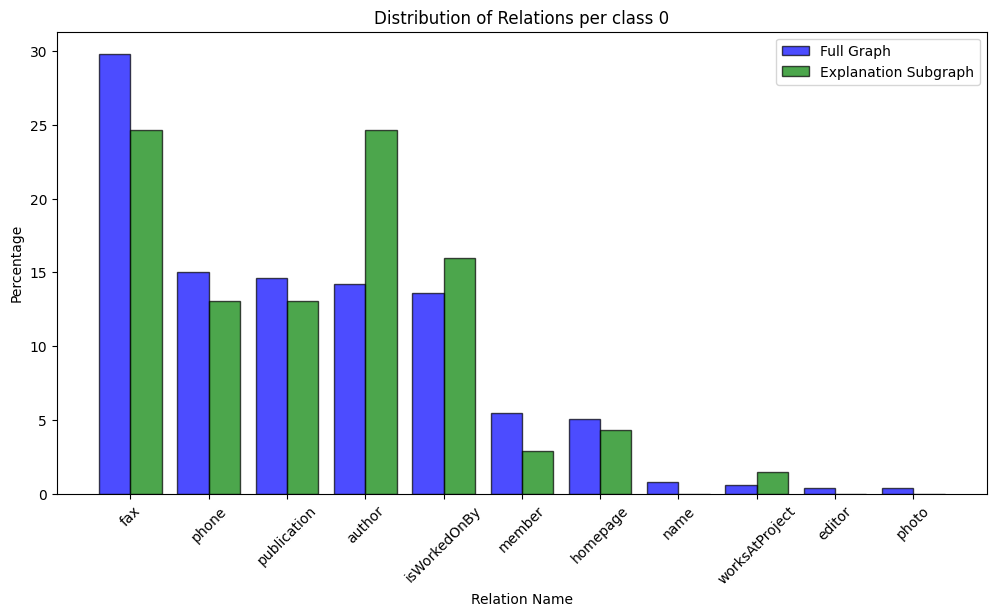

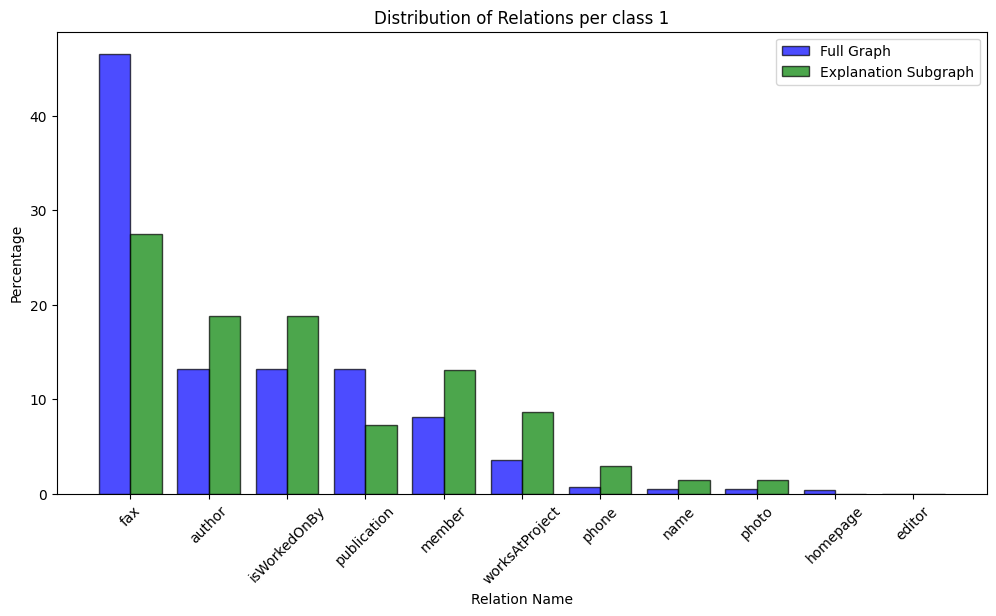

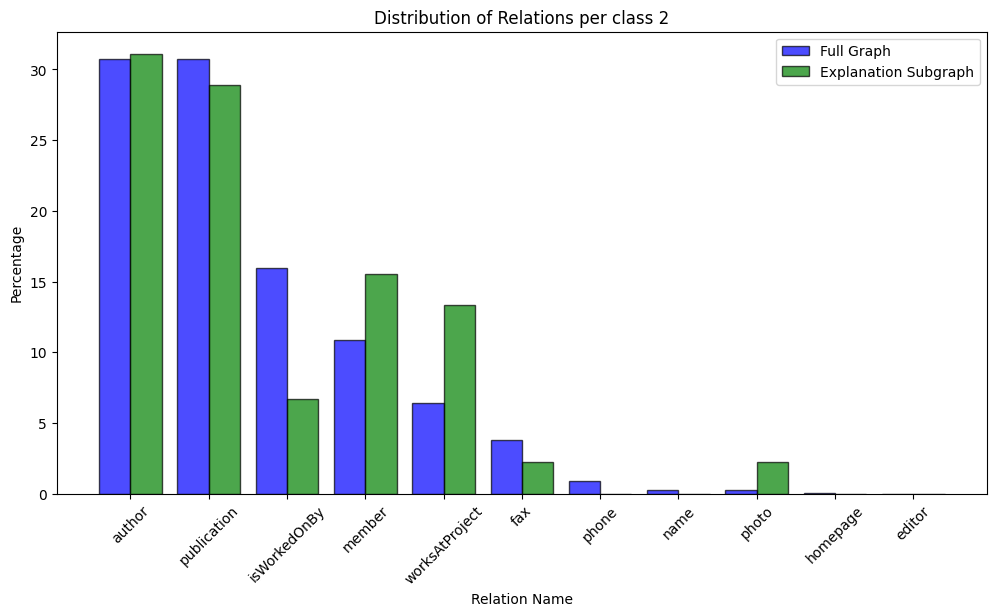

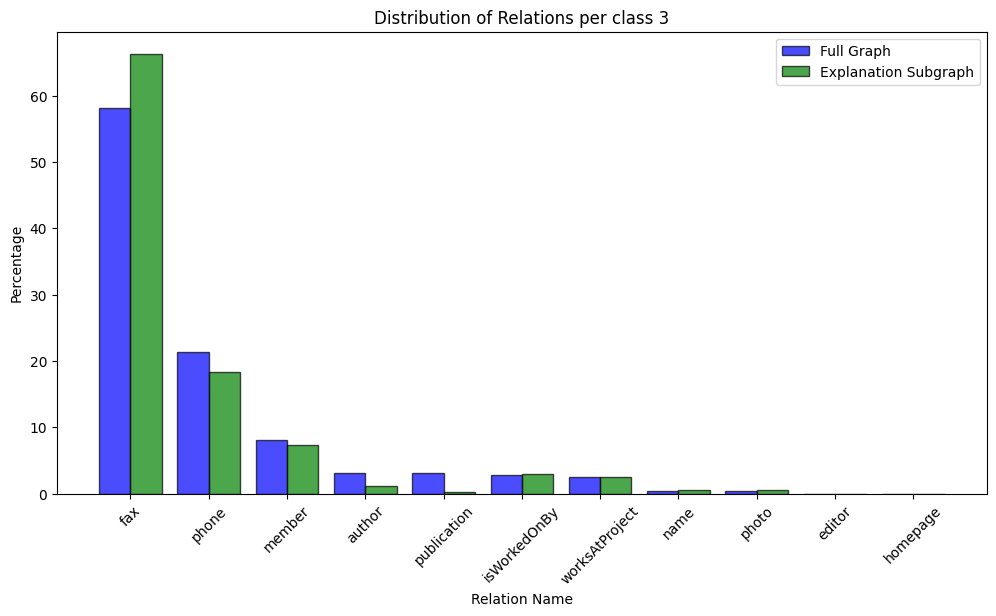

In [101]:

for label in range(data.num_classes):
    bar_plot_relations(full.loc[label].to_dict(), explain.loc[label].to_dict(),label)

In [ ]:
#statistical test about the difference between distributions of relations among classes before and after explanation

In [98]:
def fidelity(df, modality ,comparison_minus=None, comparison_inverse=None):
    ''' Compute fidelity as defined in the paper
    Args:
        df: dataframe containing the results of the experiments
         modality: minus or plus depending on the type of fidelity to compute
    '''

    mismatch_f, matc_f, accuracy_f = accuracy_func(df, comparison ='prediction_full')
    if modality == 'minus':
        mismatch_e, matc_e, accuracy_e = accuracy_func(df, comparison=comparison_minus)
        fidelity = {i: accuracy_f[i] - accuracy_e[i] for i in range(len(accuracy_f))}
        fidelity = {key: value for key, value in fidelity.items()}
        fidelity = dict(sorted(fidelity.items()))
    if modality == 'plus':
        mismatch_e, matc_e, accuracy_e = accuracy_func(df, comparison=comparison_inverse)
        fidelity = {i: accuracy_f[i] - accuracy_e[i] for i in range(len(accuracy_f))}
        fidelity = {key: value for key, value in fidelity.items()}
        fidelity = dict(sorted(fidelity.items()))

    return fidelity


def accuracy_func(df, comparison='prediction_full'):
    ''' Compute per class accuracy
    Args:
        df: dataframe containing the results of the experiments
        comparison: full, explain, explain binary, inverse
        binary: True if binary explanation is considered, False otherwise
        inverse: True if inverse explanation is considered, False otherwise
        overall: True if overall accuracy is considered, False otherwise    
    '''
    mismatch, matc = {}, {}
    match_count, mismatch_count = 0, 0

    
    for index, row in df.iterrows():

        c = np.argmax([float(num) for num in row[comparison][1:-1].split()])

        #original = int(row['label'])
        original = np.argmax(row['prediction_full'][1:-1].split())

        match_count, mismatch_count = (match_count + 1, mismatch_count) if original == c else (match_count, mismatch_count + 1)
        match_dict = matc if original == c else mismatch
        match_dict.setdefault(original, []).append(index)


    #labels = [int(i) for i in set(df['label'])]
    labels = [np.argmax([float(num) for num in row['prediction_full'][1:-1].split()]) for index, row in df.iterrows()]

    accuracy = {i: len(matc[i]) / (len(matc[i]) + len(mismatch[i])) if i in mismatch.keys() and i in matc.keys() else (1 if i not in mismatch.keys() else 0) for i in labels}
    #accuracy = {key: value for key, value in accuracy.items()}
    accuracy = dict(sorted(accuracy.items()))


    accuracy = list(accuracy.values())

    return mismatch, matc, accuracy


def result_table_norel_int(path):
    d = pd.read_csv(path+'Relations_Important_sample_threshold.csv', sep=',')
    d.set_index('node_idx', inplace=True)
    #d['label'] = d['label'].apply(lambda x: int(x[1]))

    fidelity_plus_threshold = np.round(list(fidelity(d, modality = 'plus', comparison_inverse= 'res_threshold_lekker_inverse').values()),3)
    fidelity_minus_threshold = np.round(list(fidelity(d, modality = 'minus', comparison_minus = 'prediction_threshold_lekker').values()),3)
    df = pd.DataFrame()
    sparsity = np.round(d.groupby('label')['sparsity_threshold'].mean(),3)
    df['Sparsity'] = sparsity
    df['Fidelity- '] = 1 - fidelity_minus_threshold
    df['Fidelity+ '] = fidelity_plus_threshold


    fidelity_plus_random = np.round(list(fidelity(d, modality = 'plus', comparison_inverse= 'res_random_inverse').values()),3)
    fidelity_minus_random = np.round(list(fidelity(d, modality = 'minus', comparison_minus = 'prediction_random').values()),3)
    df['Fidelity- Random'] = 1 - fidelity_minus_random
    df['Fidelity+ Random'] = fidelity_plus_random

    

    
    table = df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
    latex_table = table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
    latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    return latex_table
    
print(result_table_norel_int(path) )

\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  Sparsity &  Fidelity-  &  Fidelity+  &  Fidelity- Random &  Fidelity+ Random \\
label &           &             &             &                   &                   \\
\hline
0     &     0.982 &         1.0 &       0.000 &             1.250 &               0.0 \\
1     &     0.982 &         1.0 &       0.000 &             0.500 &               0.0 \\
2     &     0.990 &         1.0 &       1.000 &             0.000 &               1.0 \\
3     &     0.908 &         1.0 &       0.333 &             0.333 &               0.0 \\
\hline
\end{tabular}\end{adjustbox}
\end{table}



/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_43736/4172364752.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [125]:
#main 

exp = 'init_normal_hops_2_lr_0.5_adaptive_True_size_0.005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no'
path = f'chk/{name}_chk/exp/{exp}/Relation_Importance/'
full = modified_counter(path+'/Relations_Important_full_neighborhood.csv',relations)
explain = modified_counter(path+'/Relations_Important_sample_threshold.csv',relations)

# for label in range(data.num_classes):
#     bar_plot_relations(full.loc[label].to_dict(), explain.loc[label].to_dict(),label)
        
print(result_table_norel_int(path) )

\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  Sparsity &  Fidelity-  &  Fidelity+  &  Fidelity- Random &  Fidelity+ Random \\
label &           &             &             &                   &                   \\
\hline
0     &     0.981 &         1.0 &       0.000 &              1.00 &               0.0 \\
1     &     0.983 &         1.0 &       0.167 &              0.50 &               0.0 \\
2     &     0.974 &         1.0 &       0.500 &              0.50 &               0.5 \\
3     &     0.919 &         1.0 &       0.500 &              0.25 &               0.0 \\
\hline
\end{tabular}\end{adjustbox}
\end{table}



/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_43736/412155446.py:72: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  mean_df = df.groupby('label').mean()
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_43736/4172364752.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
